In [86]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import datetime
import  matplotlib.pyplot as plt

from PIL import Image
import cv2
#To use wand, insall ImageMagick library => brew install imagemagick (or) freetype imagemagick
from wand import image as wi

import tensorflow as tf
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Check for data corruption after downloading dataset

1 : PIL Image corruption check + JPEG's JFIF header check
2 : ImageMagick's Wand Image Corruption check + CV2 Image Corruption check : to handle errors like ==> Corrupt JPEG data: 65 extraneous bytes before marker 0xd9.
    - Works when we close and reopen PyCharm, and run the program for the first time (fresh session).May or may not work in subsequent runs in the same session


In [87]:
cat_path = 'Datasets/PetImages/Cat/'
dog_path = 'Datasets/PetImages/Dog/'

##### Part-1 : PIL Image corruption check + JPEG's JFIF header check
def image_corruption(dir_cd):
    corrupt_im = []
    for img_file in os.listdir(dir_cd):
        img_path = dir_cd + img_file
        if img_file.endswith('jpg'):
            try:
               im = Image.open(img_path)
               im.verify()
            except:
                corrupt_im.append(img_file)
                os.remove(img_path)

    for img_file in os.listdir(dir_cd):
        img_path = dir_cd + img_file
        if img_file.endswith('jpg'):
            fobj = open(img_path, "rb")
            jfif_boolval = tf.compat.as_bytes("JFIF") in fobj.peek(10) #filter out badly-encoded images that do not feature the string "JFIF" in their header
            if not jfif_boolval and os.path.exists(img_path):
                    corrupt_im.append(img_file)
                    os.remove(img_path)
            fobj.close()
    return corrupt_im

cat_corrupted = image_corruption(cat_path)
dog_corrupted = image_corruption(dog_path)
print("Deleted the corrupted images => Cat = ",len(cat_corrupted),", Dog = ",len(dog_corrupted),", Total = ",len(cat_corrupted)+len(dog_corrupted))

In [88]:
##### Part-2 : ImageMagick's Wand Image Corruption check + CV2 Image Corruption check
#####   to handle errors like ==> Corrupt JPEG data: 65 extraneous bytes before marker 0xd9

for img_file in os.listdir(cat_path):
    if img_file.endswith('jpg'):
        img_path = cat_path + img_file
        wi.Image(filename=img_path)

In [89]:
for img_file in os.listdir(dog_path):
    if img_file.endswith('jpg'):
        img_path = dog_path + img_file
        wi.Image(filename=img_path)

In [90]:
print("Cat :")
for img_file in os.listdir(cat_path):
    if img_file.endswith('jpg'):
        img_path = cat_path + img_file
        im = cv2.imread(img_path)

print("Dog :")
for img_file in os.listdir(dog_path):
    if img_file.endswith('jpg'):
        img_path = dog_path + img_file
        im = cv2.imread(img_path)

In [91]:
cat_corrupt = ['1418.jpg','1614.jpg','6421.jpg','7201.jpg','12303.jpg']
dog_corrupt = ['3119.jpg','4297.jpg','4323.jpg','4352.jpg','5936.jpg','7002.jpg','7654.jpg','12100.jpg']

corrupt_images = [os.path.join(cat_path,img) for img in cat_corrupt]
corrupt_images.extend([os.path.join(dog_path,img) for img in dog_corrupt])

for img_path in corrupt_images:
    os.remove(img_path)

### Load dataset
- Each Image size = 150X150 pixels

In [92]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/PetImages/',
    labels = 'inferred',
    label_mode = 'binary',
    #batch_size = 20,
    image_size=(150,150),
    validation_split=0.1, ###If `subset` is set, `validation_split` must be set, and inversely
    subset = 'training', ###If `subset` is set, `validation_split` must be set, and inversely
    shuffle=True,  ###False = Get same results
    seed = 16
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/PetImages/',
    labels = 'inferred',
    label_mode = 'binary',
    #batch_size = 20,
    image_size=(150,150),
    validation_split=0.1, ###If `subset` is set, `validation_split` must be set, and inversely
    subset = 'validation', ###If `subset` is set, `validation_split` must be set, and inversely
    shuffle=True,  ###False = Get same results
    seed = 16
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/rv-test-dog-or-cat/',
    image_size=(150,150),
    label_mode=None, #Does not return label
    shuffle=False,
    seed = 22
)
print(train_ds,val_ds,test_ds)

Found 23395 files belonging to 2 classes.
Using 21056 files for training.
Found 23395 files belonging to 2 classes.
Using 2339 files for validation.
Found 8 files belonging to 1 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <BatchDataset element_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None)>


### EDA

#### Dog = 1, Cat = 0

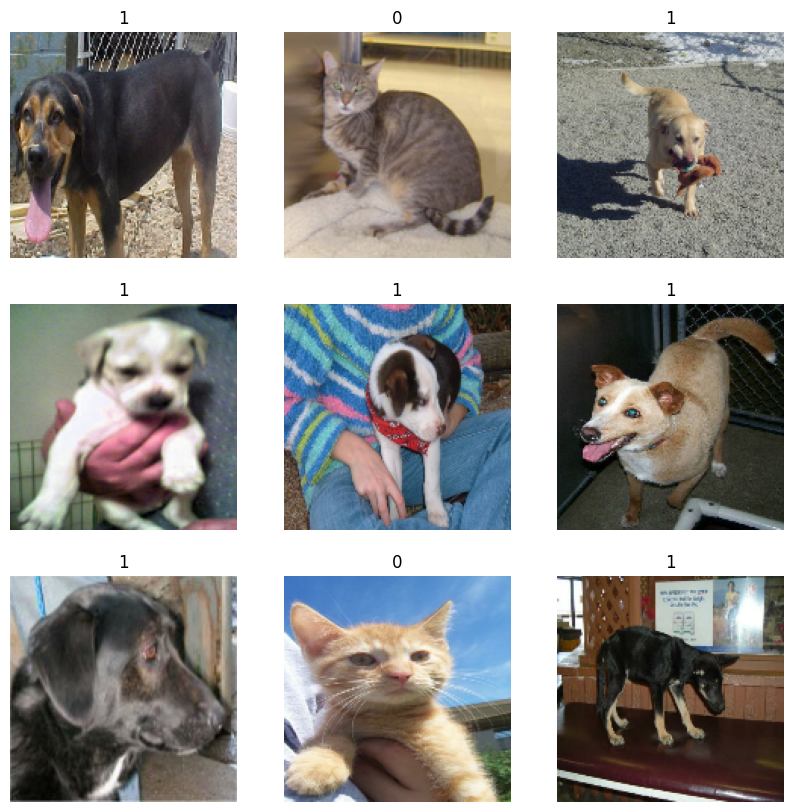

In [93]:
##### Training Set or/and Validation Set

#i = 0
#for x,y in val_ds: #train_ds
#    i += 1
#    print("Batch ",i)
#    #print("####### X (",i,") = ",x.shape,type(x))
#    #print("####### Y (",i,") = ",y.shape,type(y))

#print("Last batch (",i,") = ",x.shape,type(x))
#plt.imshow(x.numpy()[0].astype('uint8'))  #Float values
#plt.show()

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        #If label is an array, plt.title([x for x in labels[i].numpy().astype("uint8")])
        plt.axis("off")

### Feature scaling (Normalization) => Preprocessing layer

- Data augmentation is inactive at inference time

In [94]:
#!pip install tensorflow-gpu==2.8.3
#https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting

In [95]:
# PPL - Option 1 : Part of model
#rescale_layer = tf.keras.layers.Rescaling(scale=1./255,input_shape=(300,300,3))

# PPL Option 2 : Apply to dataset
#rescale_layer = tf.keras.layers.Rescaling(scale=1./255)
#train_ds = train_ds.map(lambda x,y : (rescale_layer(x),y))
#val_ds = val_ds.map(lambda x,y : (rescale_layer(x),y))

train_rescale_augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest'), #360 degrees = 100% => 90 deg = 25% (0.25), 45 deg = 0.125
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    #tf.keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(height_factor=0.2,fill_mode='nearest'),
    tf.keras.layers.RandomFlip(mode='horizontal')
])
train_ds = train_ds.map(lambda x,y : (train_rescale_augment(x),y))

val_test_rescale = tf.keras.layers.Rescaling(scale=1./255)
val_ds = val_ds.map(lambda x,y : (val_test_rescale(x),y))
test_ds_scaled = test_ds.map(lambda x : val_test_rescale(x))

### Build MODEL

- (default) steps_per_epoch = No.of training samples//batch_size

In [96]:
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,verbose=1)
callback_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'Models/C2W1DogsCats/Checkpoint/dc_model', #_{epoch}',
    monitor = 'val_accuracy',save_best_only = True,save_weights_only = True,verbose=1)
#class AccCheck(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#        if logs['accuracy'] >= 0.99:
#            print("Reached 99% accuracy so cancelling training!")
#            self.model.stop_training = True
tb_log_dir = "Models/C2W1DogsCats/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback_tb = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1, write_graph=True)

dc_model = tf.keras.models.Sequential([
    #rescale_layer,
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [97]:
dc_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)    

In [98]:
dc_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [99]:
dc_model_hist = dc_model.fit(train_ds,
             validation_data = val_ds,
             epochs = 5,
             steps_per_epoch = 100,
             validation_steps = 50,
             callbacks = [callback_tb,callback_cp])

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5188
Epoch 1: val_accuracy improved from -inf to 0.61563, saving model to Models/C2W1DogsCats/Checkpoint/dc_model
100/100 [==============================] - 114s 1s/step - loss: 0.6910 - accuracy: 0.5188 - val_loss: 0.6767 - val_accuracy: 0.6156
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5841
Epoch 2: val_accuracy did not improve from 0.61563
100/100 [==============================] - 119s 1s/step - loss: 0.6737 - accuracy: 0.5841 - val_loss: 0.6538 - val_accuracy: 0.6125
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.6103
Epoch 3: val_accuracy improved from 0.61563 to 0.62875, saving model to Models/C2W1DogsCats/Checkpoint/dc_model
100/100 [==============================] - 124s 1s/step - loss: 0.6590 - accuracy: 0.6103 - val_loss: 0.6401 - val_accuracy: 0.6288
Epoch 4/5
100/100 [============================

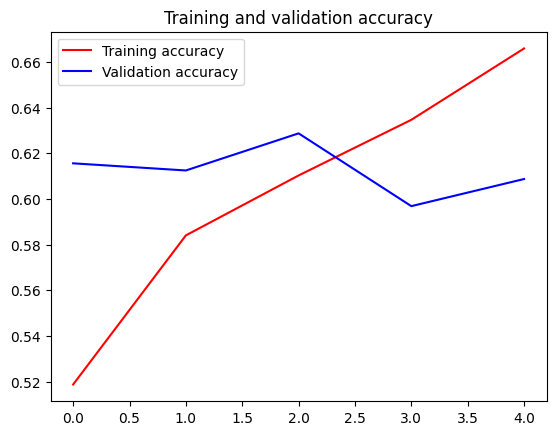

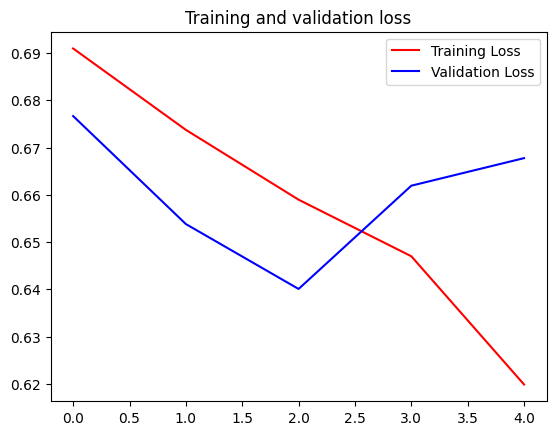

In [100]:
# Plot the model results
acc = dc_model_hist.history['accuracy']
val_acc = dc_model_hist.history['val_accuracy']
loss = dc_model_hist.history['loss']
val_loss = dc_model_hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [101]:
# Save the model, and reload it

dc_model.save('Models/C2W1DogsCats/C2W1_ImageClassification_DogsCats_model.h5')
new_dc_model = tf.keras.models.load_model('Models/C2W1DogsCats/C2W1_ImageClassification_DogsCats_model.h5')
new_dc_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)    

In [102]:
%tensorboard --logdir 'Models/C2W1DogsCats/logs/'

Launching TensorBoard...

### Predict

#### Dog = 1, Cat = 0

1/1 [==============================] - 0s 318ms/step
[[0.77295935]
 [0.56498975]
 [0.8449865 ]
 [0.18456736]
 [0.7550643 ]
 [0.18456736]
 [0.954901  ]
 [0.91930276]]
(8, 150, 150, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
Dog


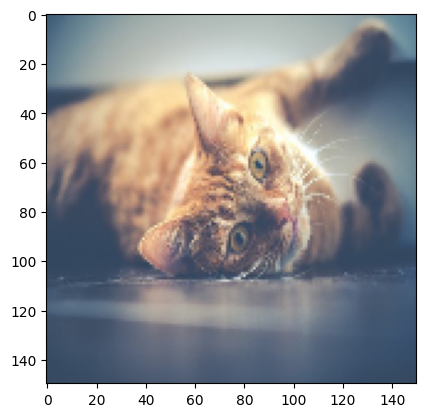

Dog


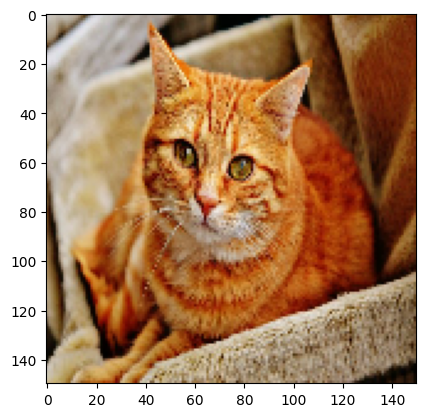

Dog


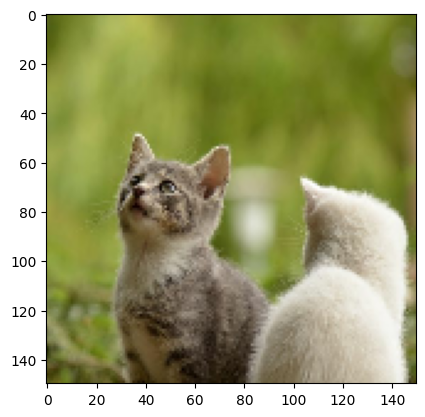

Cat


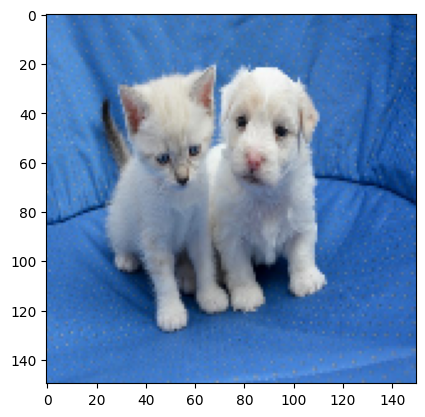

Dog


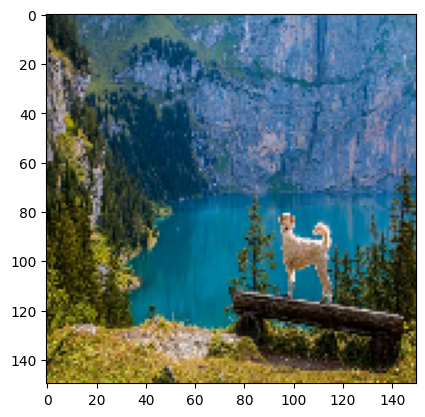

Cat


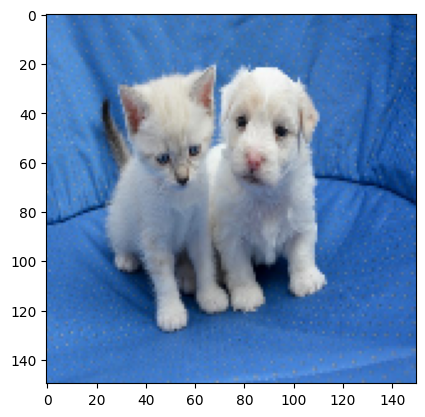

Dog


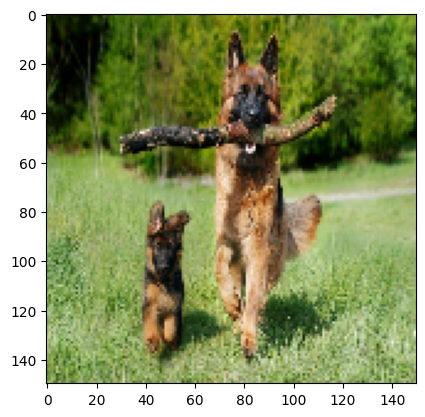

Dog


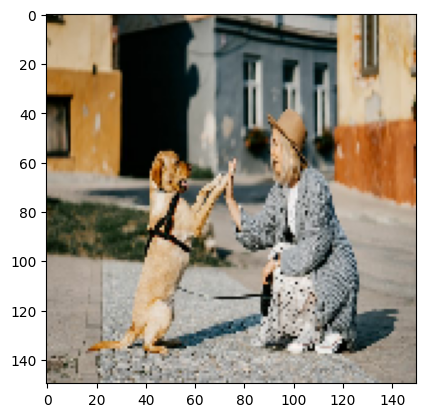

In [103]:
y_pred = dc_model.predict(test_ds_scaled) #new_dc_model.predict(test_ds_scaled)
print(y_pred)
y_pred_label = ["Cat" if el<0.5 else "Dog" for el in y_pred ]

##### Test Set

for x in test_ds:
    print(x.shape,type(x))
    if(x.shape[0]<32):
        for i in range(0,x.shape[0]):
            print(y_pred_label[i])
            plt.imshow(x.numpy()[i].astype('uint8'))  #Float values
            plt.show()